ISMIR 2016 Tutorial  
Introduction to EEG Decoding  
for Music Information Retrieval Research  
  
# Part II - Working with Epoched Data
Sebastian Stober  
dataset: [https://purl.stanford.edu/js383fs8244](https://purl.stanford.edu/js383fs8244)  
software libs: mne-python, numpy, scipy, matplotlib.pyplot

In [1]:
# download the data for this notebook
def download(urls, target_path):
    import os
    import urllib
    
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    
    for u in urls:
        filepath = os.path.join(target_path, u.split('/')[-1])
        if not os.path.exists(filepath):
            print 'downloading', u
            urllib.urlretrieve(u, filepath)
        else:
            print 'skipping', filepath

In [2]:
        
download(['https://stacks.stanford.edu/file/druid:js383fs8244/P1_preprocessed.mat',
          'https://stacks.stanford.edu/file/druid:js383fs8244/P2_preprocessed.mat'],
#          TODO: P1_3d.mat, P2_3d.mat, Hydrocel GSN 128 1.0.sfp
         'data/')

skipping data/P1_preprocessed.mat
skipping data/P2_preprocessed.mat


In [3]:
# optional, if CUDA available
import mne
mne.utils.set_config('MNE_USE_CUDA', 'true') 

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import HTML
from IPython.display import display

import numpy as np
import scipy.io
import os

In [4]:
# little helpers for nicer graphics
figsize=(17,10)

def resize(w=17, h=10):
    plt.gcf().set_size_inches(w, h, forward=True) # trick to increase size for show=False

In [5]:
# define some lookup-structures for the trigger labels
stimuli = {
    25:'C-tonic',
    30:'C-dominant',
    35:'C-flatII',
    40:'C-silence',
    45:'F-tonic',
    50:'F-dominant',
    55:'F-flatII',
    60:'F-silence',
    65:'B-tonic',
    70:'B-dominant',
    75:'B-flatII',
    80:'B-silence',
}

groups = {
    'tonic': ('25','45','65'),
    'dominant': ('30','50','70'),
    'flatII': ('35','55','75'),
    'silence': ('40','60','80')
}

In [9]:
# load matlab data
mat = scipy.io.loadmat('data/P1_3d.mat')
print mat.keys()
data = mat['x3D']
print data.shape   # electrodes x time x trials

IOError: [Errno 2] No such file or directory: 'data/P1_3d.mat'

In [6]:
# convert data shape
trials = np.rollaxis(data, 2, 0)
print trials.shape # trials x channels x time

NameError: name 'data' is not defined

In [6]:
# check range
print trials.min(), trials.mean(), trials.max() 
# looks like this is off by factor 1000

-16.6781176418 2.00806965492e-19 28.5082116363


In [7]:
# convert range
trials /= 1000.

In [8]:
print trials.min(), trials.mean(), trials.max() # much better

-0.0166781176418 2.17689603861e-22 0.0285082116363


In [9]:
# load trial labels
mat = scipy.io.loadmat('data/P1_preprocessed.mat')
events = mat['Triggers'].squeeze()
print len(events)
print len(np.unique(events))
labels, counts = np.unique(events, return_counts=True)
print labels
print counts

1296
12
[25 30 35 40 45 50 55 60 65 70 75 80]
[108 108 108 108 108 108 108 108 108 108 108 108]


In [10]:
# convert events array to MNE format: [time, duration, label] per event
trial_len = trials.shape[-1]
print events[:10]
events_ = np.vstack([np.arange(0, trials.shape[0]*trial_len, trial_len), 
                     np.zeros_like(events), 
                     events]).T
print events_.shape
print events_[:10]

[60 50 45 55 70 75 65 80 70 65]
(1296, 3)
[[  0   0  60]
 [ 39   0  50]
 [ 78   0  45]
 [117   0  55]
 [156   0  70]
 [195   0  75]
 [234   0  65]
 [273   0  80]
 [312   0  70]
 [351   0  65]]


124 channels


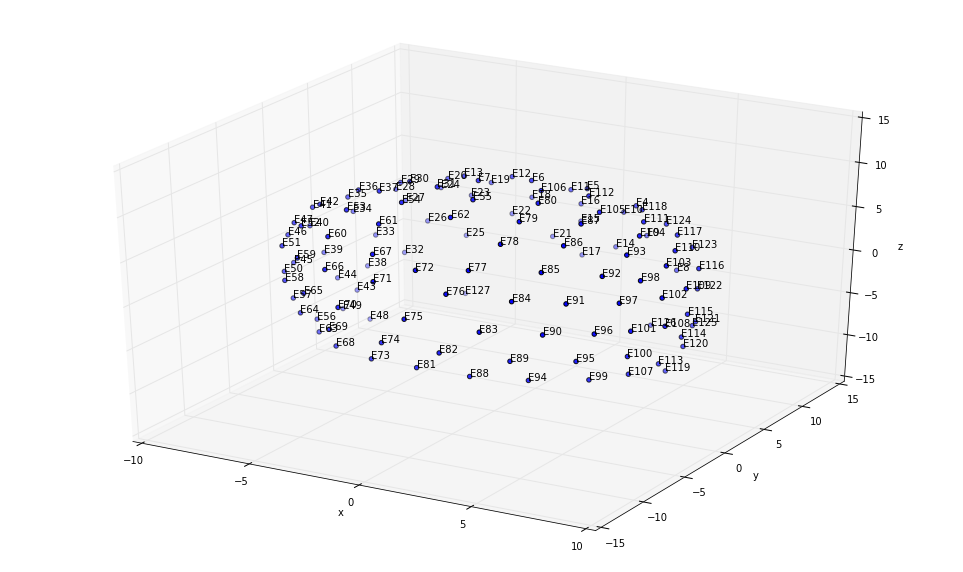

In [11]:
# load electrode montage
selected_channels = ['E{}'.format(i) for i in range(4,128)] # select electrodes 4..127
montage = mne.channels.read_montage(kind='Hydrocel GSN 128 1.0', # note: without extension
                                    path='data/',
                                    ch_names=selected_channels) 
print len(montage.ch_names), 'channels'
mne.viz.plot_montage(montage, show_names=True, show=False)
resize() # this is usually interactive

In [12]:
# create info element
sampling_rate = 62.5 # Hz
info = mne.create_info(ch_names=montage.ch_names, 
                       sfreq=sampling_rate, 
                       ch_types=['eeg'] * len(montage.ch_names),
                       montage=montage)

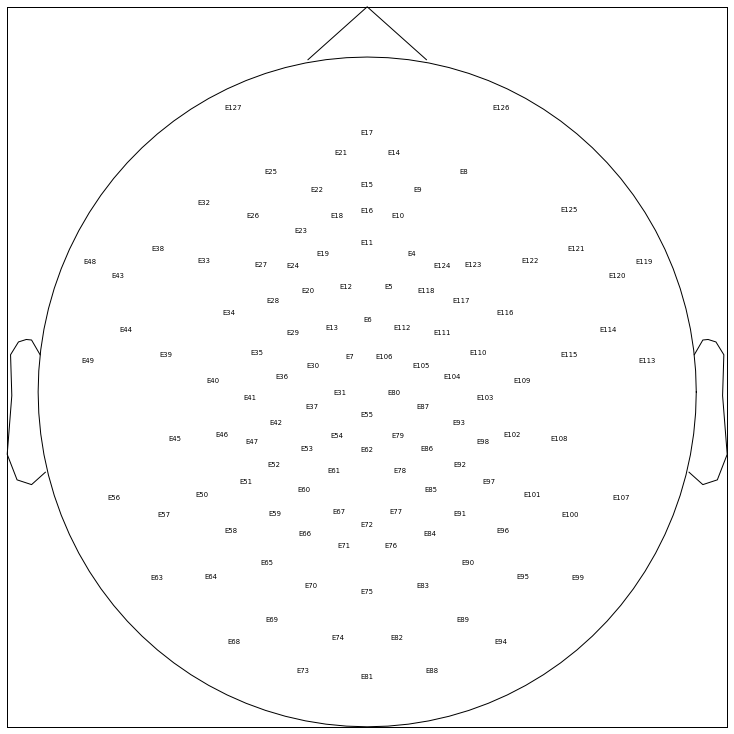

In [13]:
# a layout is needed for plotting topo maps (in 2D)
layout = mne.channels.make_eeg_layout(info)
layout.plot(show=False)
resize(10,10)

In [14]:
# create epochs
epochs = mne.epochs.EpochsArray(data=trials, events=events_, 
                                info=info, tmin=0)

1296 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [15]:
print epochs.info

<Info | 15 non-empty fields
    bads : list | 0 items
    ch_names : list | E4, E5, E6, E7, E8, E9, E10, E11, E12, E13
    chs : list | 124 items (EEG: 124)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 31.25 Hz
    meas_date : numpy.ndarray | 1970-01-01 01:00:00
    nchan : int | 124
    projs : list | 0 items
    sfreq : float | 62.5 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    buffer_size_sec : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    filename : NoneType
    hpi_subsystem : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layout : NoneType
>


In [16]:
d = epochs._data
print d.min(), d.mean(), d.std(), d.max()

-0.0166781176418 1.82953373366e-22 0.000105182893139 0.0285082116363


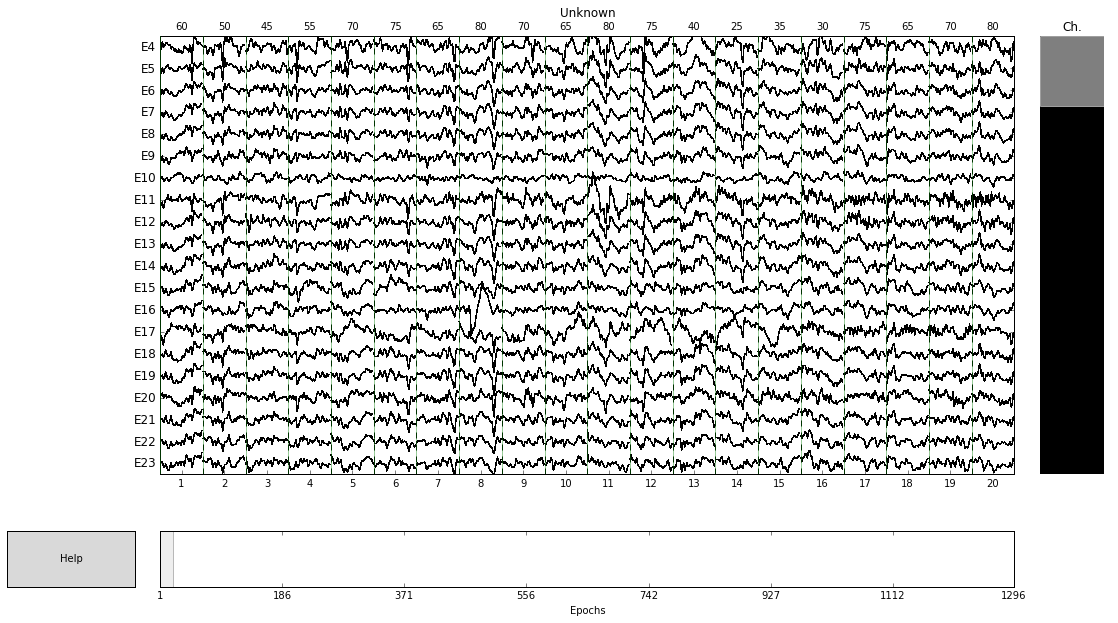

In [17]:
# plot some epochs (this is usually interactive when not inline)
epochs.plot(show=False, scalings=dict(eeg=30e-5))   # manual scaling for nicer display
resize()

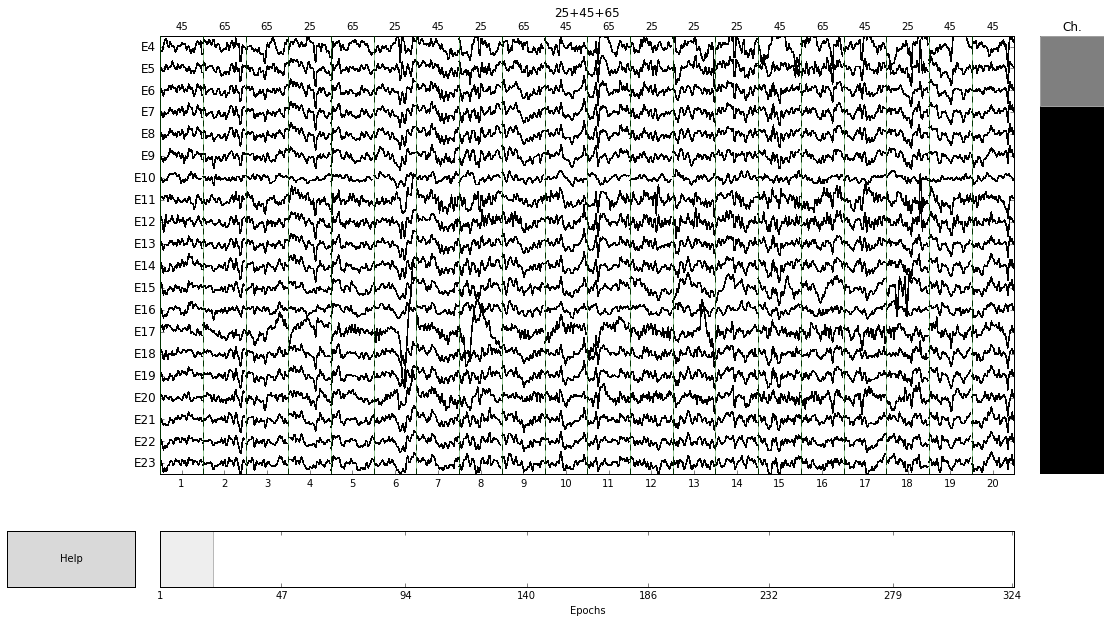

In [18]:
# just the tonic condition
epochs[groups['tonic']].plot(show=False, scalings=dict(eeg=30e-5))   # manual scaling for nicer display
resize()

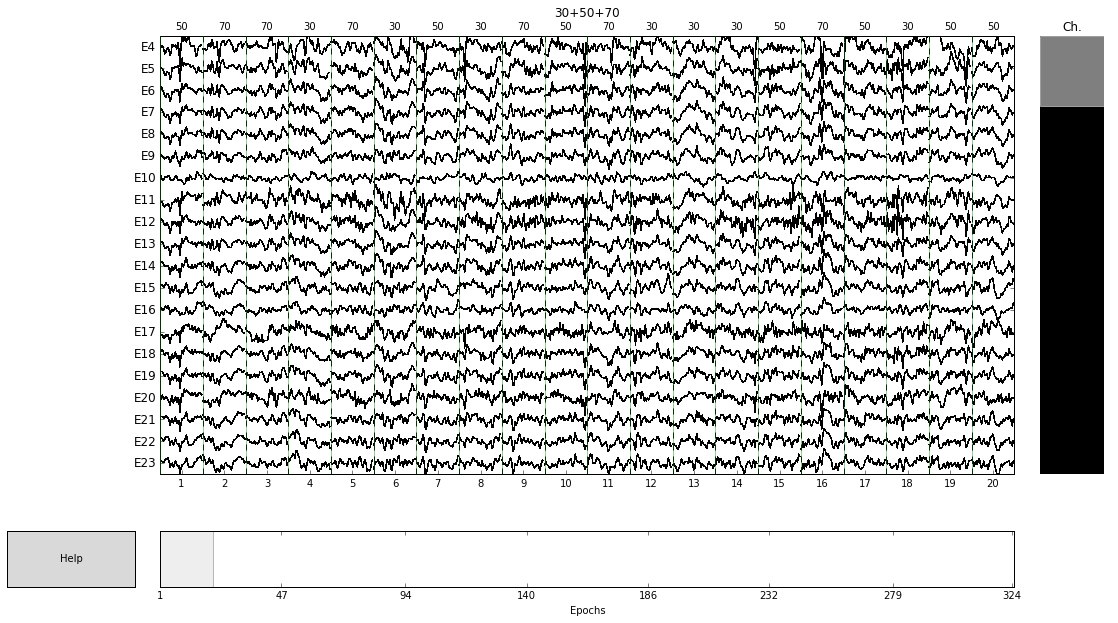

In [19]:
# just the dominant condition
epochs[groups['dominant']].plot(show=False, scalings=dict(eeg=30e-5))   # manual scaling for nicer display
resize()

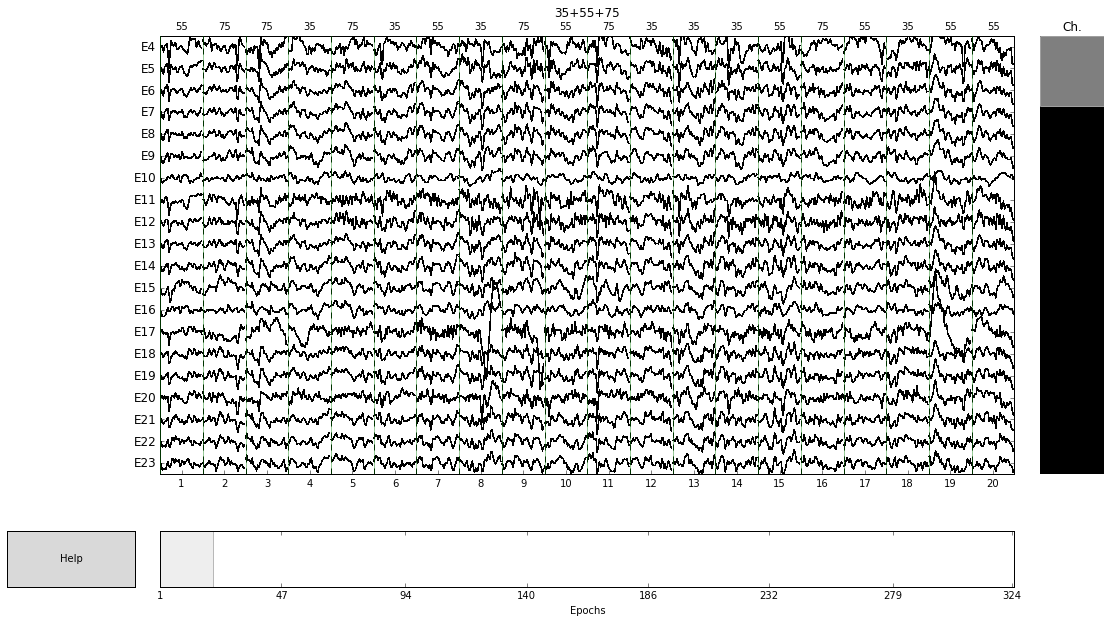

In [20]:
# just the flatII condition
epochs[groups['flatII']].plot(show=False, scalings=dict(eeg=30e-5))   # manual scaling for nicer display
resize()

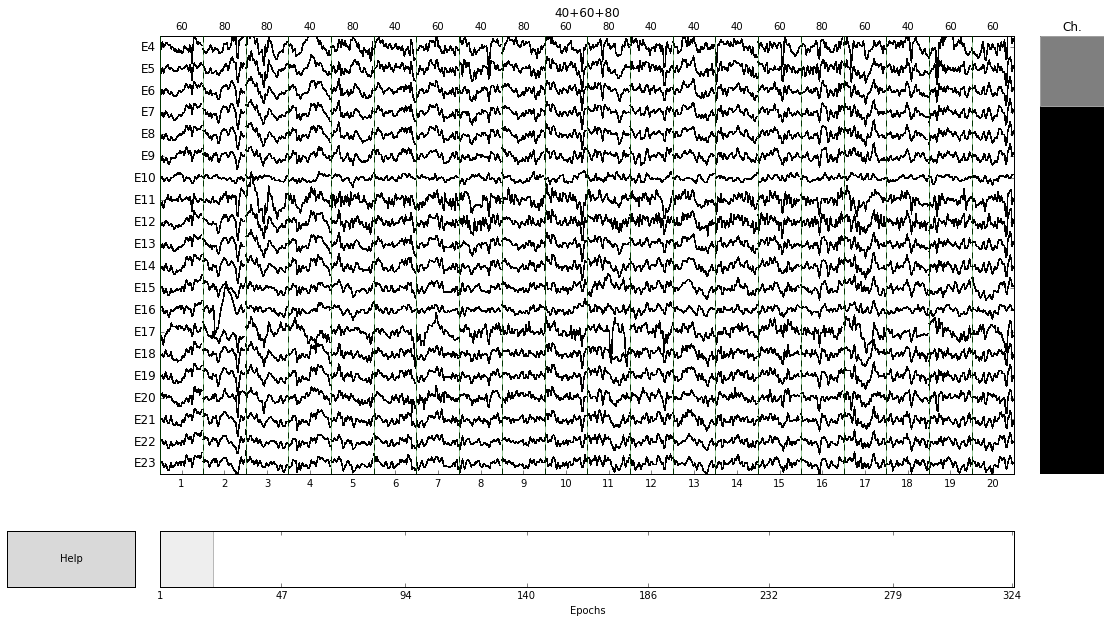

In [21]:
# just the silence condition
epochs[groups['silence']].plot(show=False, scalings=dict(eeg=30e-5))   # manual scaling for nicer display
resize()

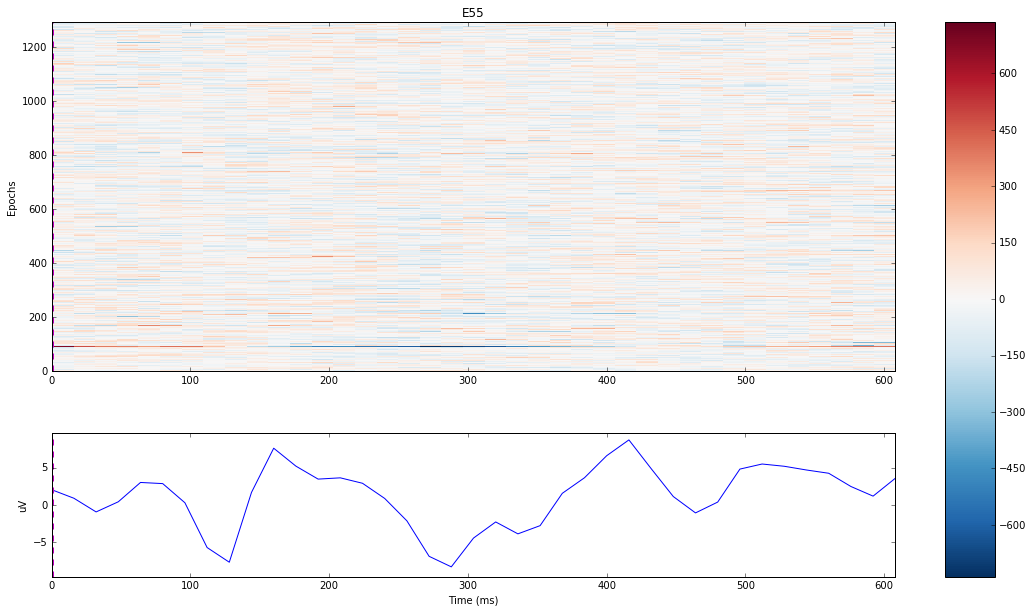

In [22]:
# plot a single electrode (E55=center) for all epochs
epochs.plot_image(51, show=False)
resize()

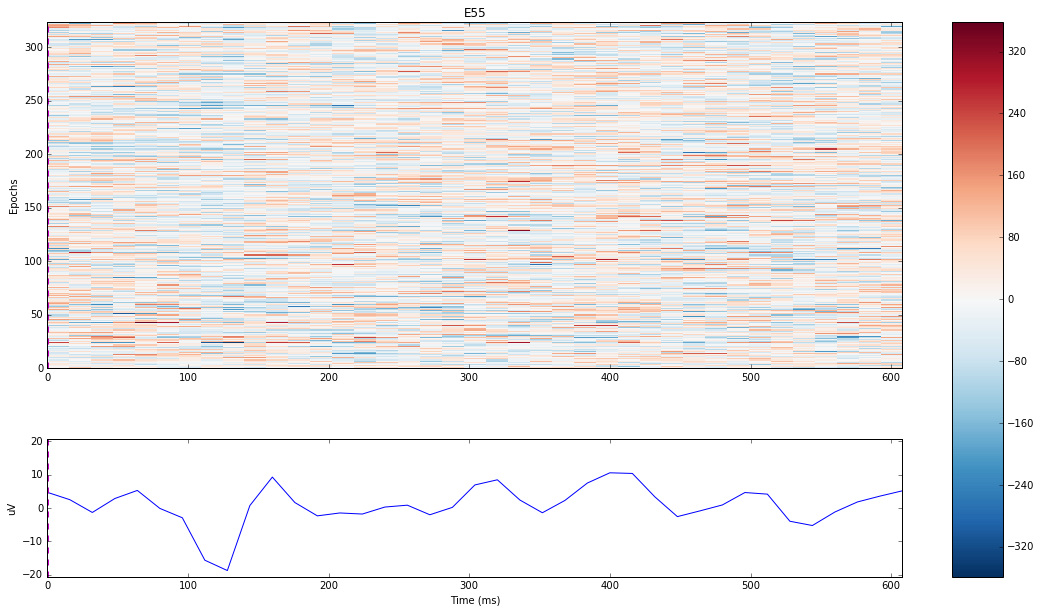

In [23]:
epochs[groups['tonic']].plot_image(51, show=False)
resize()

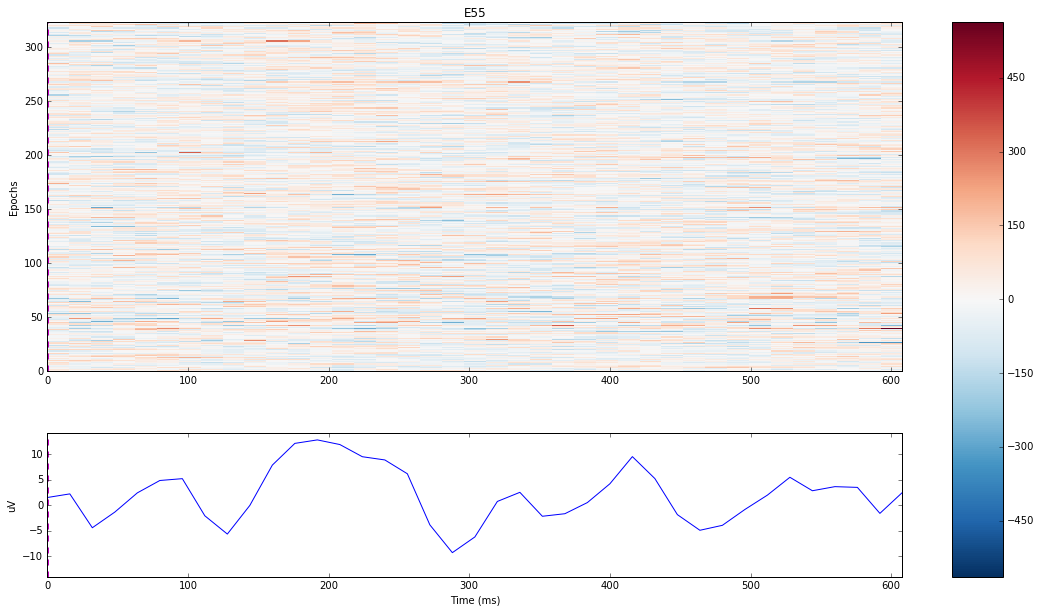

In [24]:
epochs[groups['dominant']].plot_image(51, show=False)
resize()

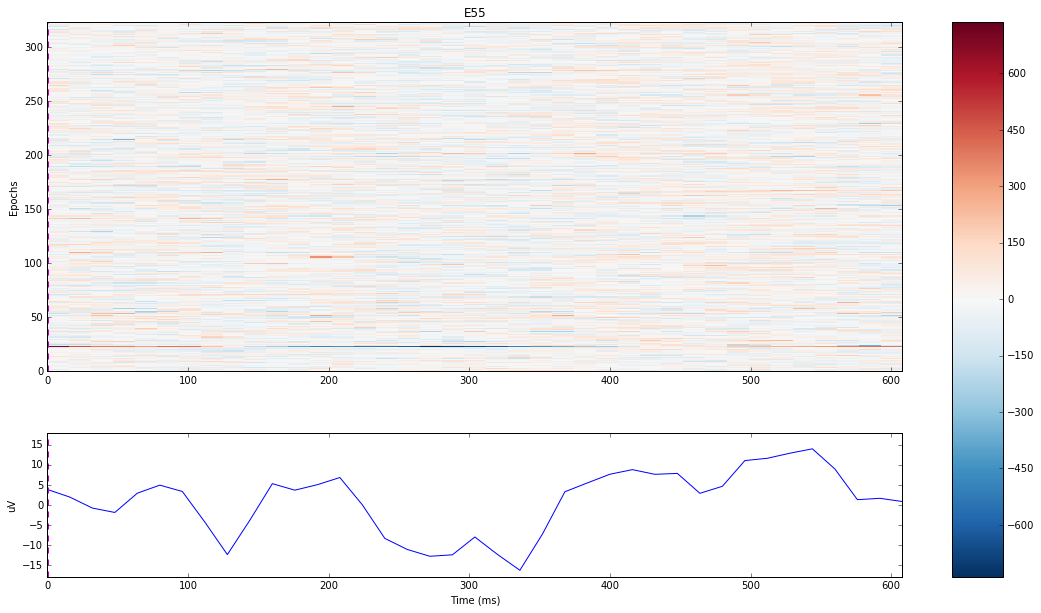

In [25]:
epochs[groups['flatII']].plot_image(51, show=False)
resize()

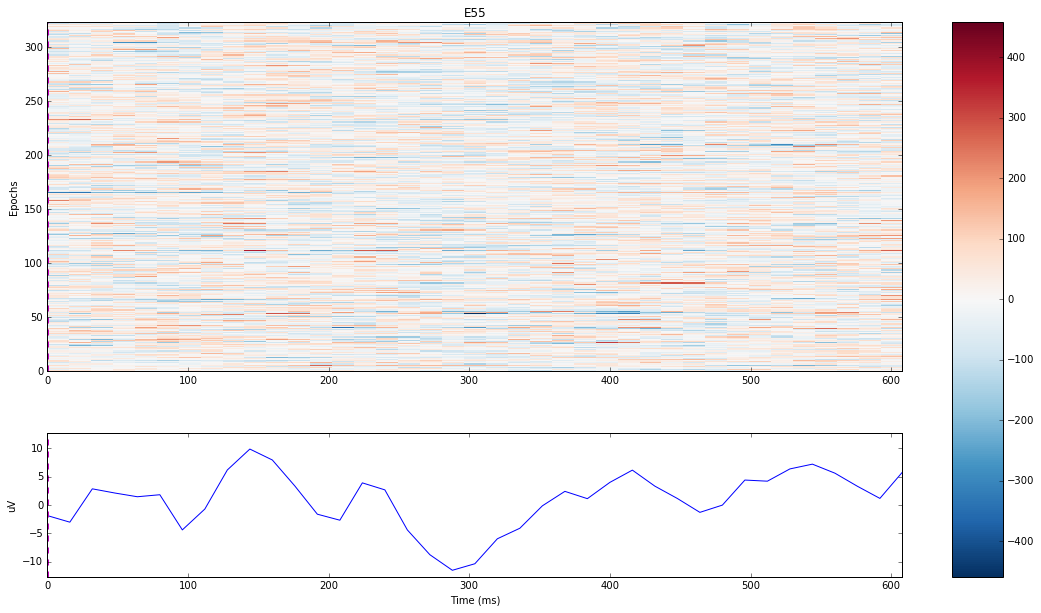

In [26]:
epochs[groups['silence']].plot_image(51, show=False)
resize()

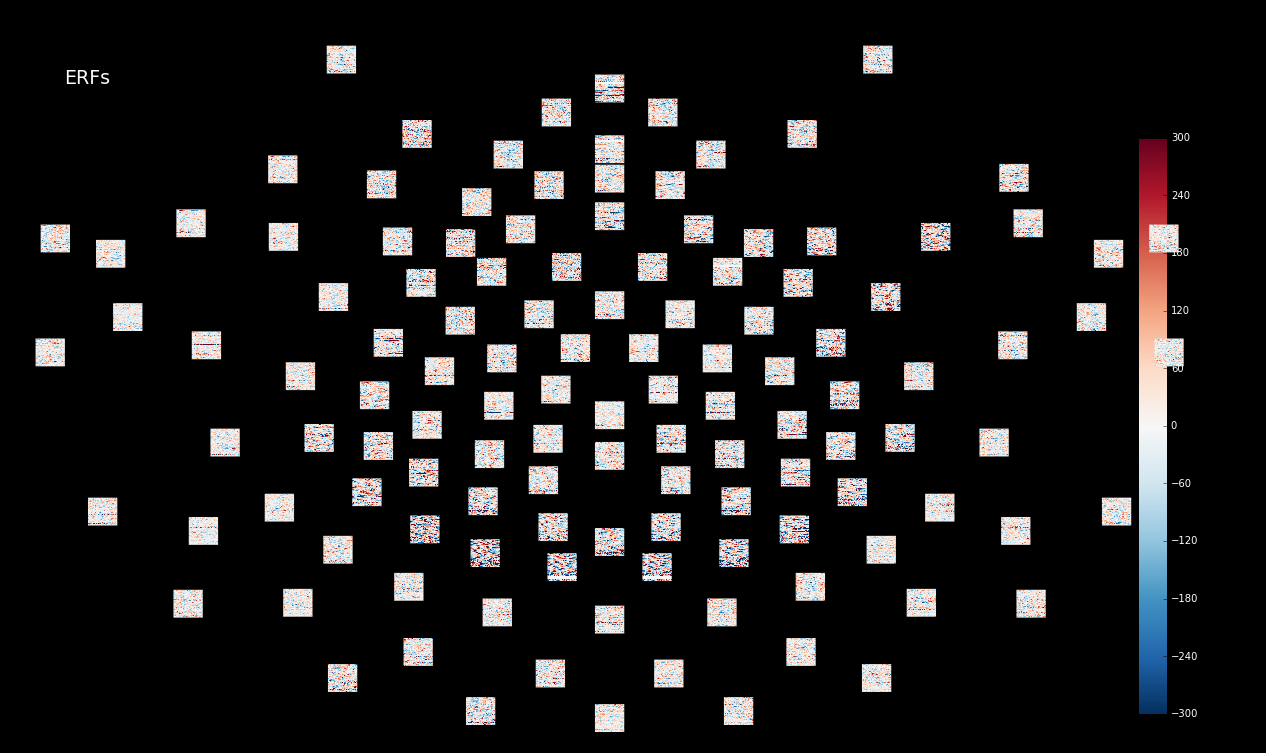

In [27]:
# epochs[groups['tonic']].plot_topo_image(title='ERFs', show=False) # bad range
epochs[groups['tonic']].plot_topo_image(title='ERFs', vmin=-300, vmax=300, show=False)
resize()

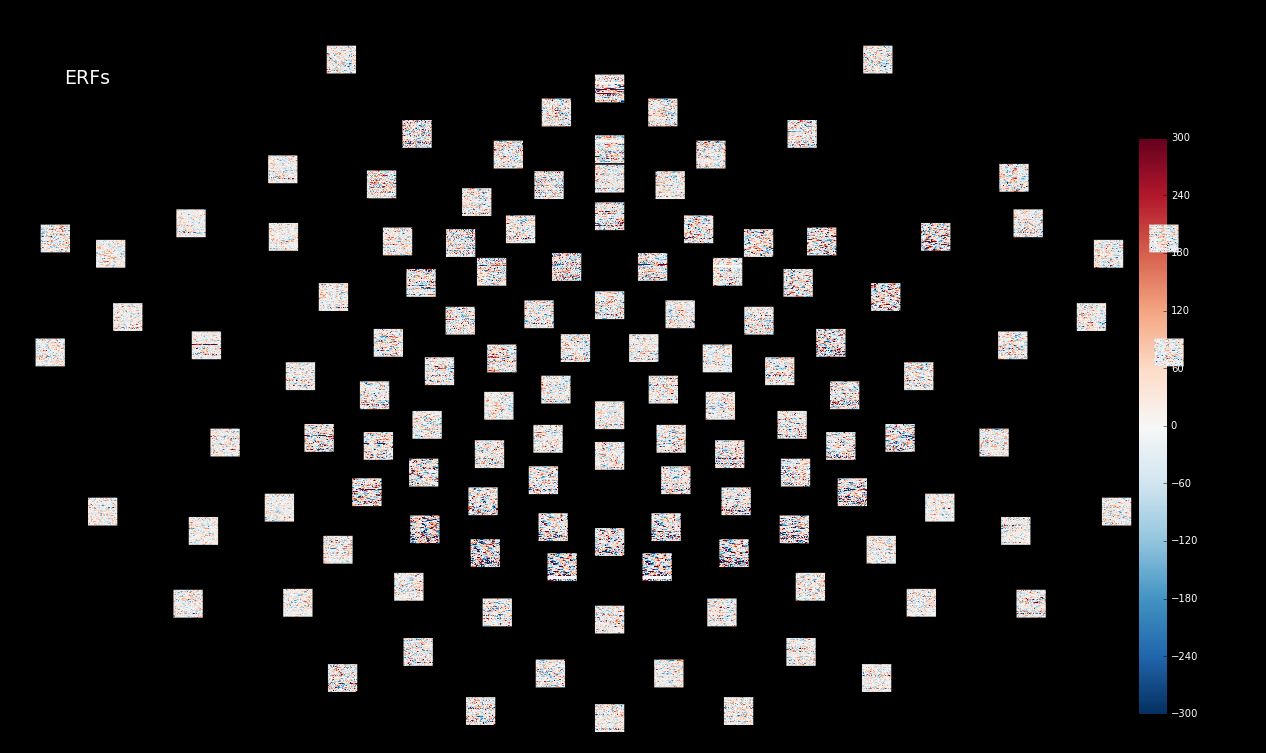

In [29]:
epochs[groups['silence']].plot_topo_image(title='ERFs', vmin=-300, vmax=300, show=False)
resize()

In [ ]:
# # plot one EPR per (key x condition)
# for l in labels:
#     print l, stimuli[l]
#     epochs[str(l)].average().plot();

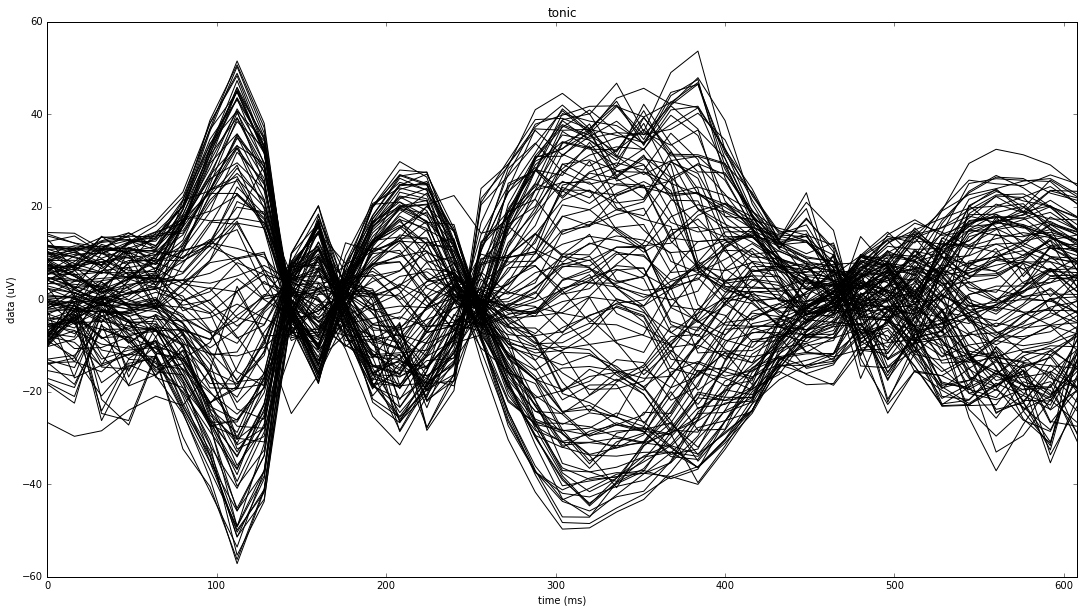

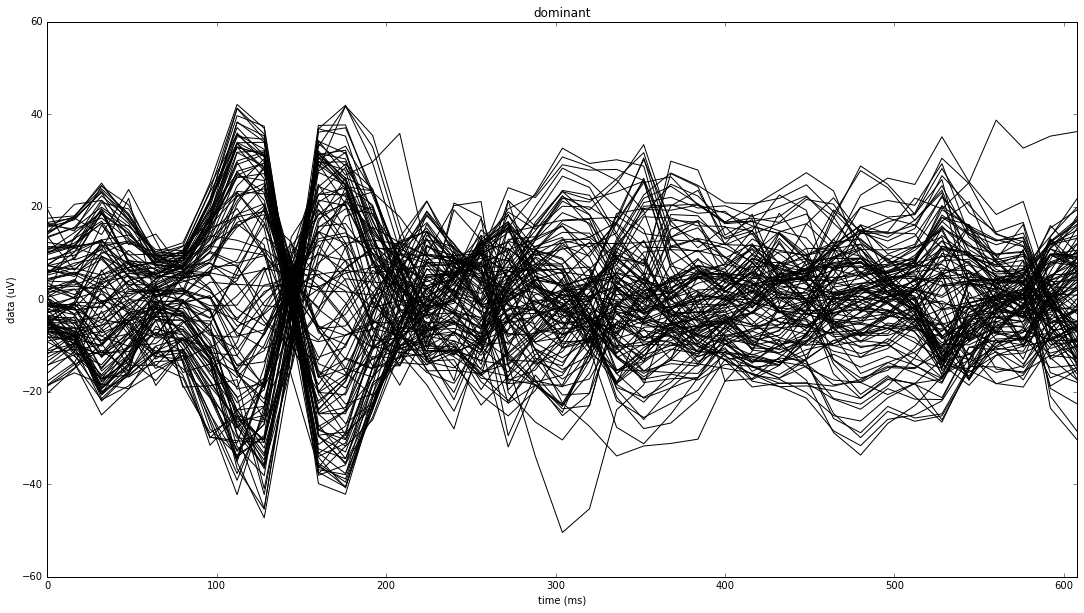

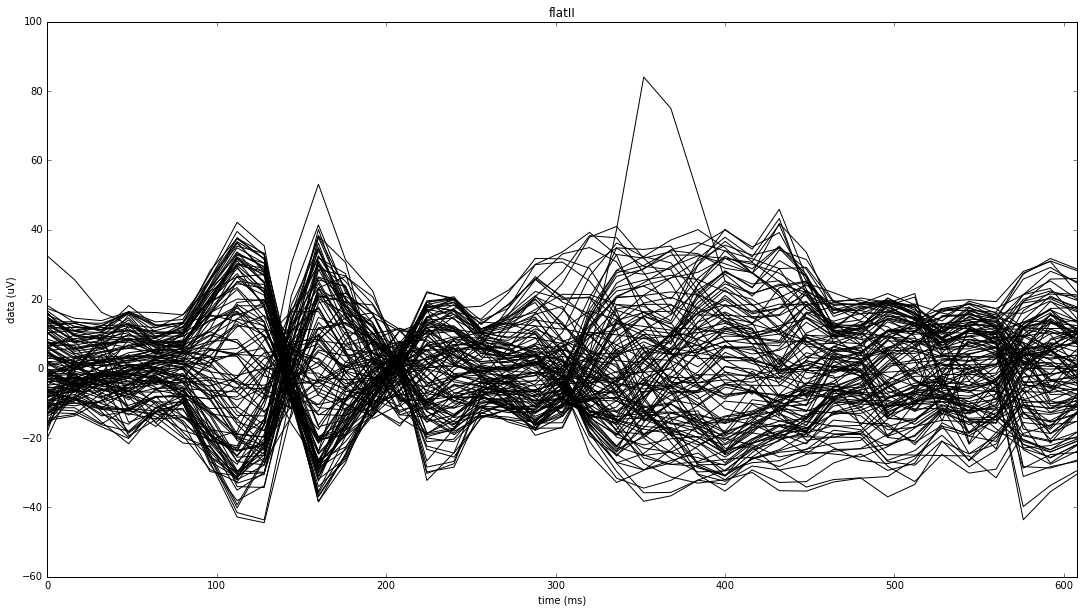

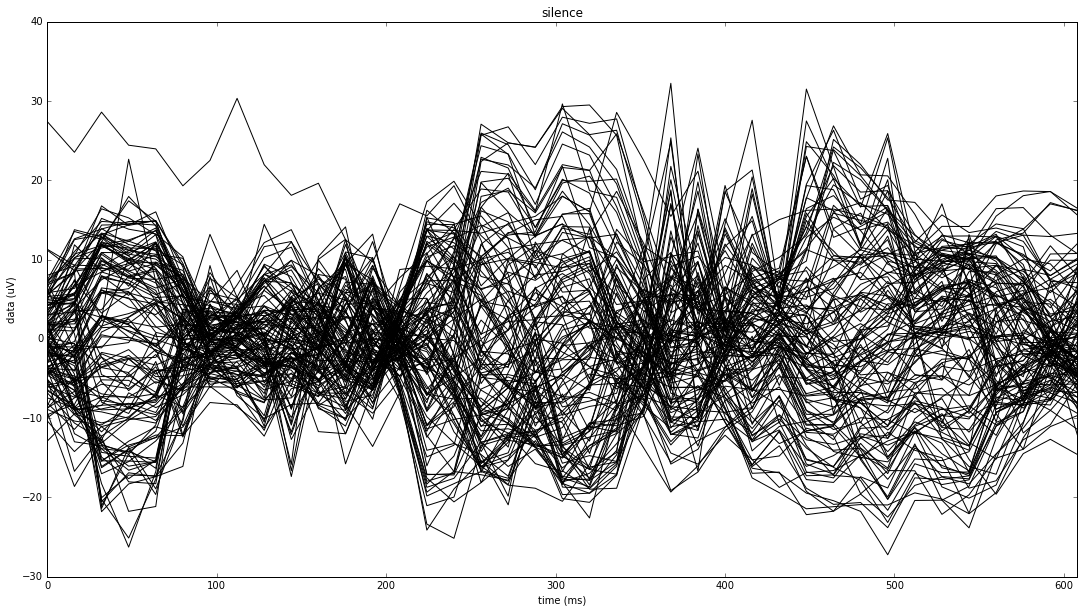

In [30]:
for label, group in groups.items(): # plot EPR per condition
    epochs[group].average().plot(window_title=label, show=False); 
    plt.title(label); resize()

In [ ]:
# animated topomaps
# JS Animation import is available at http://github.com/jakevdp/JSAnimation
# from JSAnimation.IPython_display import display_animation

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
import matplotlib.gridspec as gridspec

def animate_evoked_topomap(evoked, layout, title, output_filepath):
    
    scale = 1e-6
    vmax = abs(evoked.data).max()/scale
    vmin = -vmax
    data = evoked.data/scale
    #print data.shape

    scale_time = 1e3
    times = evoked.times * scale_time
    
    fig = plt.figure(figsize=(12,5))
    plt.suptitle(title)
    subplot_grid = gridspec.GridSpec(1, 3)
    
    axes2 = plt.subplot(subplot_grid[0, :2])
    axes2.plot(times, data.T, color='lightgrey')
    axes2.set_xlim(times[0], times[-1])
    axes2.set_xlabel('time (ms)')
    axes2.set_ylabel('data (uV)') 
    progress = axes2.plot(times, data.T, color='k')

    axes = plt.subplot(subplot_grid[0, 2])

    def animate(i):
        t = evoked.times[i]
        tp, _ = mne.viz.plot_topomap(data[:, i], layout.pos, vmin=vmin, vmax=vmax,
                              sensors=True, res=64, names=layout.names,
                              show_names=False, cmap='RdBu_r',
                              axes=axes, contours=False)        

        axes.set_title('%01d ms' % (t * scale_time))

        for j, line in enumerate(progress):
            line.set_data(times[:i+1], data[j, :i+1].T)

        print 'plotting image', i, 'of', len(evoked.times) # just to see some progress
        return progress
    
    def init():
        tp = animate(0)    
        for line in progress:
            line.set_data([], [])
        return progress


    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(times), interval=1) #, blit=True)

    if output_filepath is not None:
    #     writer = animation.writers['ffmpeg'](fps=30)
    #     anim.save('demo.mp4',writer=writer,dpi=dpi)
        print 'writing', output_filepath
        anim.save(output_filepath, writer='imagemagick')

    # call our new function to display the animation
    return anim

# TODO: A colorbar would be nice

In [ ]:
# generate animated gifs
for label, group in groups.items():
    output_filepath='{}.gif'.format(label)
    if os.path.exists(output_filepath): continue
    evoked = epochs[group].average()
    anim = animate_evoked_topomap(evoked, layout, title=label, output_filepath=output_filepath)

In [33]:
display(HTML('<img src="tonic.gif">'))

In [34]:
display(HTML('<img src="dominant.gif">'))

In [35]:
display(HTML('<img src="flatII.gif">'))

In [36]:
display(HTML('<img src="silence.gif">'))